<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/kospi_dart_buyback_resale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 코스피 상장사들의 자기주식 취득/처분결정 현황은 어떻게 될까?

**※ 데이터 수집 및 시각화 방향**

**1. OpenDART를 통해 자기주식 관련 금감원 공시 내용 수집하기**
전체 자사주 **"직접"** 처분하기로 **결정한** 수량의 추이를 확인

**2. 금감원 공시에서 자사주 처분방법을 구분하기**
장내 수량이 얼마나 많을까? 다른 처분방법별 특징은 어떻게 될까?


#### 코랩 환경에서 데이터 수집, 시각화를 하기 위해 필요한 라이브러리를 설치

In [1]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np
from datetime import datetime

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


#### 금감원 공시를 통해 자사주 **직접 처분** 통계 불러오기

이 데이터는 주요사항보고서(자사주처분) 공시기준 데이터이기 때문에, 실제 처분수량과는 차이가 있습니다.<br>

###### 검색기준 설정하기
검색 기준은 "유가", "2015~2024"년으로 하였습니다. 참고로 **OpenDart는 2015년부터 데이터를 제공**합니다.<br>

데이터를 불러오는 방식은 requests.post 입니다. Post방식을 위해서는 params를 설정해야 하는데, 이 안에 검색 기준이 들어가게 됩니다.<br>
취득이 경우 보고서 코드가 11332였지만, 이번에는 처분이므로 보고서 코드를 11333으로 수정합니다.

In [2]:
# 데이터 검색기준 설정하기
start_y = "2015"
end_y = "2024"
corp_type = "P" #유가는 "P", 코스닥은 "A", 유가및코스닥은 ["P", "A"] 입력
reportCode = "11333" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": f"{reportCode}",
    "corpType" : f"{corp_type}"
}

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11333',
 'corpType': 'P'}

###### 총 몇건, 몇페이지인지 확인하기
지금같이 10년치 데이터를 확인하려면 데이터의 행이 많을 것입니다.<br>
그런데 OpenDart 웹은 기본적으로 한 페이지에 표출시켜줄 수 있는 데이터의 양이 정해져 있습니다. 따라서 10년치를 검색하면 여러 페이지에 걸쳐서 데이터가 나뉘어 표출됩니다.<br>
여러 페이지에 걸쳐 loop을 돌려야 할텐데, 몇 페이지가 있는지 어떻게 확인할까요?<br>
첫번째 페이지를 크롤링 했을 때, 그 결과물에는 전체 페이지가 얼마나 되는지 정보가 포함되어 있습니다. 그리고 이 정보를 통해 총 페이지가 2이상인 것으로 확인되는 경우, 그 페이지수만큼 추가로 크롤링을 수행해야 합니다.<br>
<br>
우선 첫번째 페이지의 크롤링을 수행해 봅니다.<br>
취득을 수행했을 때 코드에서 업데이트한 부분은 다음과 같습니다. 취득건수는 1,000건이 안되어서 정규표현식 때 콤마를 인식하는 내용을 포함하지 않았었습니다. 그러나 처분의 경우 1,000건을 넘어서 이 부분을 포함시켰습니다.

In [3]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)
content = req.content.decode('utf-8')

# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
# 백만단위 건수는 아닐거라는 가정임. 즉, 콤마가 많아도 하나만 있다는 가정임
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)?,?(\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts_before_comma = match.group(3)
    total_counts_after_comma = match.group(4)
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts_before_comma},{total_counts_after_comma}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 11
total_counts: 1,007


총 1,007건이 있고, 총 11페이지에 걸쳐있습니다.<br>
###### 데이터 수집하기
그럼 7번의 loop으로 HTML에 포함된 데이터프레임을 추출하고, 합치는 과정(pd.concat)을 진행하도록 하겠습니다.<br>
한편, 페이지 수를 확인하기 위해 이미 requests.post 한번 날려서 이미 'content'라는 변수를 받아놓았으므로, 첫번째 페이지의 데이터는 그것을 사용하고, 2페이지부터는 새로 requsts.post를 날리도록 하겠습니다.

In [4]:
# 데이터를 수집할 빈 데이터프레임(마스터 데이터프레임) 생성
df_dart_buyback = pd.DataFrame()

# 이미 받아놓은 값(content)에서 첫번째 페이지의 데이터프레임 파싱
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

# 마스터 데이터프레임에 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  # 마스터 데이터프레임에 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

###### 수집된 데이터프레임 형태 확인
데이터프레임이 어떤 형태인지 한번 확인해 보겠습니다.

In [5]:
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th>회사명</th>
      <th>접수일</th>
      <th colspan="2" halign="left">처분예정주식(주)</th>
      <th colspan="2" halign="left">처분 대상 주식가격(원)</th>
      <th colspan="2" halign="left">처분예정금액(원)</th>
      <th colspan="2" halign="left">처분예정기간</th>
      <th>처분목적</th>
      <th colspan="4" halign="left">처분방법</th>
      <th>위탁투자중개업자</th>
      <th colspan="8" halign="left">처분 전 자기주식 보유현황</th>
      <th>처분결정일</th>
      <th colspan="2" halign="left">사외이사참석여부</th>
      <th>감사 (사외이사가 아닌 감사위원) 참석여부</th>
      <th colspan="2" halign="left">1일 매도 주문수량 한도</th>
      <th>비고</th>
    </tr>
    <tr>
      <th>회사명</th>
      <th>접수일</th>
      <th colspan="2" halign="left">처분예정주식(주)</th>
      <th colspan="2" halign="left">처분 대상 주식가격(원)</th>
      <th colspan="2" halign="left">처분예정금액(원)</th>
      <th colspan="2" halign="left">처분예정기간</th>
      <th>처분목적</th>
      <th>시장을 통한 매도(주)</th>
      <th>시간외대량매매(주)</th>
      <th>장외처분(주)</th>
   

In [6]:
df_dart_buyback.head()

회사명         접수일 처분예정주식(주)      처분 대상 주식가격(원)          처분예정금액(원)       \
        회사명         접수일 처분예정주식(주)      처분 대상 주식가격(원)          처분예정금액(원)        
        회사명         접수일      보통주식 기타주식          보통주식 기타주식          보통주식 기타주식   
0   유AJ네트웍스  2023-06-20    484943    -          4720    -    2288930960    -   
1    유AK홀딩스  2018-04-12    150000    -         37491    -    5623650000    -   
2  유BNK금융지주  2020-02-06     14855    -          6940    -     103093700    -   
3       유CJ  2019-12-09   1140809    -        121450    -  138551253050    -   
4   유CJ대한통운  2015-10-02    202338    -        196513    -   39762047394    -   

          처분예정기간                 ... 처분 전 자기주식 보유현황                 \
          처분예정기간                 ...        기타취득(주)                  
             시작일            종료일  ...          비율(%)   기타주식 비율(%).1   
0  2023년 05월 15일  2023년 08월 14일  ...            1.0      -       -   
1  2018년 04월 23일  2018년 04월 23일  ...            1.2      -       -   
2  2020년 02월 07일  2020년 05월 06일  ...           0.00      -       -   
3  2019년 12월 27일  2019년 12월 27일  ...            5.2  14252       -   
4  2015년 12월 16일  2015년 12월 16일  ...           23.6      -       -   

           처분결정일 사외이사참석여부       감사 (사외이사가 아닌 감사위원) 참석여부 1일 매도 주문수량 한도       \
           처분결정일 사외이사참석여부       감사 (사외이사가 아닌 감사위원) 참석여부 1일 매도 주문수량 한도        
           처분결정일    참석(명) 불참(명) 감사 (사외이사가 아닌 감사위원) 참석여부          보통주식 기타주식   
0  2023년 05월 12일        2     0                      참석             -    -   
1  2018년 03월 23일        3     -                       -             -    -   
2  2020년 02월 06일        7     0                       -        183764    -   
3  2019년 04월 29일        4     -                       -             -    -   
4  2015년 10월 02일        4     -                       -             -    -   

                    비고  
                    비고  
                    비고  
0  2023년 06월 20일 최종보고서  
1  2018년 04월 12일 최종보고서  
2                    -  
3  2019년 12월 09일 최종보고서  
4                    -  

[5 rows x 31 columns]

확인해보니 칼럼이 3층으로 되어 있습니다. 이런 경우 분석을 하기 번거로워지는 점이 있으니, 칼럼을 1층으로 포개 주도록 하겠습니다.
3층을 1층으로 포갤때 칼럼명이 어떻게 되는지를 먼저 확인하고, 중복된 내용은 없애서는 방식으로 칼럼명을 수정하도록 하겠습니다.

In [7]:
# 3층을 1층으로 포개었을 때 어떤 칼럼명들이 생성되는지 확인
print(['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns])

['회사명_회사명_회사명', '접수일_접수일_접수일', '처분예정주식(주)_처분예정주식(주)_보통주식', '처분예정주식(주)_처분예정주식(주)_기타주식', '처분 대상 주식가격(원)_처분 대상 주식가격(원)_보통주식', '처분 대상 주식가격(원)_처분 대상 주식가격(원)_기타주식', '처분예정금액(원)_처분예정금액(원)_보통주식', '처분예정금액(원)_처분예정금액(원)_기타주식', '처분예정기간_처분예정기간_시작일', '처분예정기간_처분예정기간_종료일', '처분목적_처분목적_처분목적', '처분방법_시장을 통한 매도(주)_시장을 통한 매도(주)', '처분방법_시간외대량매매(주)_시간외대량매매(주)', '처분방법_장외처분(주)_장외처분(주)', '처분방법_기타(주)_기타(주)', '위탁투자중개업자_위탁투자중개업자_위탁투자중개업자', '처분 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_보통주식', '처분 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%)', '처분 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_기타주식', '처분 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%).1', '처분 전 자기주식 보유현황_기타취득(주)_보통주식', '처분 전 자기주식 보유현황_기타취득(주)_비율(%)', '처분 전 자기주식 보유현황_기타취득(주)_기타주식', '처분 전 자기주식 보유현황_기타취득(주)_비율(%).1', '처분결정일_처분결정일_처분결정일', '사외이사참석여부_사외이사참석여부_참석(명)', '사외이사참석여부_사외이사참석여부_불참(명)', '감사 (사외이사가 아닌 감사위원) 참석여부_감사 (사외이사가 아닌 감사위원) 참석여부_감사 (사외이사가 아닌 감사위원) 참석여부', '1일 매도 주문수량 한도_1일 매도 주문수량 한도_보통주식', '1일 매도 주문수량 한도_1일 매도 주문수량 한도_기타주식', '비고_비고_비고']


매매방식을 기재하는 방식에서 취득공시와 다른 점이 있습니다.
* 자사주취득공시 : 처분방식을 ***하나의 칸에 free text로 기재***합니다.
* 자사주처분공시 : 처분방식을 ***시장, 시간외대량, 장외, 기타로 구분***을 하였고, 각각의 방식으로 처분할 수량을 기재하도록 하였습니다.

<br>
취득공시보다 처분공시에서 데이터 활용성이 높아졌습니다!

###### 데이터프레임 전처리

In [8]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_buyback.columns = ['회사명', '접수일',
                           '처분예정주식(주)_보통주식', '처분예정주식(주)_기타주식',
                           '처분 대상 주식가격(원)_보통주식', '처분 대상 주식가격(원)_기타주식',
                           '처분예정금액(원)_보통주식', '처분예정금액(원)_기타주식',
                           '처분예상기간_시작일','처분예상기간_종료일',
                           '처분목적',
                           '처분방법_시장을 통한 매도(주)',
                           '처분방법_시간외대량매매(주)',
                           '처분방법_장외처분(주)',
                           '처분방법_기타(주)',
                           '위탁투자중개업자',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_보통주식',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_비율(%)',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_기타주식',
                           '처분 전 자기주식 보유현황_배당가능이익 범위 내 처분(주)_비율(%).1',
                           '처분 전 자기주식 보유현황_기타처분(주)_보통주식',
                           '처분 전 자기주식 보유현황_기타처분(주)_비율(%)',
                           '처분 전 자기주식 보유현황_기타처분(주)_기타주식',
                           '처분 전 자기주식 보유현황_기타처분(주)_비율(%).1',
                           '처분결정일',
                           '사외이사참석여부_참석(명)', '사외이사참석여부_불참(명)',
                           '감사 (사외이사가 아닌 감사위원) 참석여부',
                           '1일 매도 주문수량 한도_보통주식', '1일 매도 주문수량 한도_기타주식',
                           '비고']

데이터프레임에 몇가지의 조치를 더 취합니다.
1. 분석에 필요한 칼럼만 남깁니다.<br>
물론 우선주에 대한 자기주식 취득도 있지만, 우선주가 상장되지 않은 경우가 더 많기 때문에, 보통주에 관한 것으로 한정합니다.
2. 단위를 조정합니다.<br>
칼럼이 현재는 일괄로 str타입으로 되어있습니다. 따라서 분석을 위해 날짜, 숫자 형태 등으로 변경합니다. 또한 주단위(주 → 백만주), 원단위(원 → 억원)를 변환합니다.
3. 회사명을 조정합니다.<br
OpenDart API가 아닌 웹페이지에서 크롤링해오다보니, 회사명에 다음과 같은 수식어들이 붙어있습니다. 이러한 수식어들을 제거하는 절차를 수행합니다.
  * 시장구분자(유, 코, 넥, 기)가 회사명의 앞부분에 있습니다.
  * IR홈페이지가 있는 경우, 회사명 뒷부분에 'IR'이 붙어있습니다.

In [9]:
# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_buyback = df_dart_buyback[['회사명', '접수일',
                           '처분예정주식(주)_보통주식',
                           '처분예정금액(원)_보통주식',
                           '처분예상기간_시작일','처분예상기간_종료일',
                           '처분목적',
                           '처분방법_시장을 통한 매도(주)',
                           '처분방법_시간외대량매매(주)',
                           '처분방법_장외처분(주)',
                           '처분방법_기타(주)']].copy()

df_dart_buyback.columns = ['회사명', '접수일',
                           '처분예정주식','처분예정금액','처분시작일','처분종료일',
                           '처분목적', '장내매매', '시간외대량매매', '장외매매', '기타']

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback['접수일'] = pd.to_datetime(df_dart_buyback['접수일'])
df_dart_buyback['연도'] = df_dart_buyback['접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['처분예정주식'] = pd.to_numeric(
    df_dart_buyback['처분예정주식'], errors='coerce').fillna(0)

df_dart_buyback['처분예정금액'] = pd.to_numeric(
    df_dart_buyback['처분예정금액'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback['회사명'] = df_dart_buyback['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)


###### 전처리한 데이터프레임 확인

In [10]:
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>AJ네트웍스</td>
      <td>2023-06-20</td>
      <td>484943.0</td>
      <td>22.889310</td>
      <td>2023년 05월 15일</td>
      <td>2023년 08월 14일</td>
      <td>직원에 대한 상여금 지급</td>
      <td>-</td>
      <td>-</td>
      <td>-</td>
      <td>484943</td>
      <td>2023</td>
    </tr>
    <tr>
      <td>AK홀딩스</td>
      <td>2018-04-12</td>
      <td>150000.0</td>
      <td>56.236500</td>
      <td>2018년 04월 23일</td>
      <td>2018년 04월 23일</td>
      <td>우리사주조합원에 대한 회사이익공유 및 근로의욕 고취를 위하여 우리사주조합에 유상 매각</td>
      <td>-</td>
      <td>-</td>
      <td>150000</td>
      <td>-</td>
      <td>2018</td>
    </tr>
    <tr>

#### 자사주 직접취득 데이터 시각화

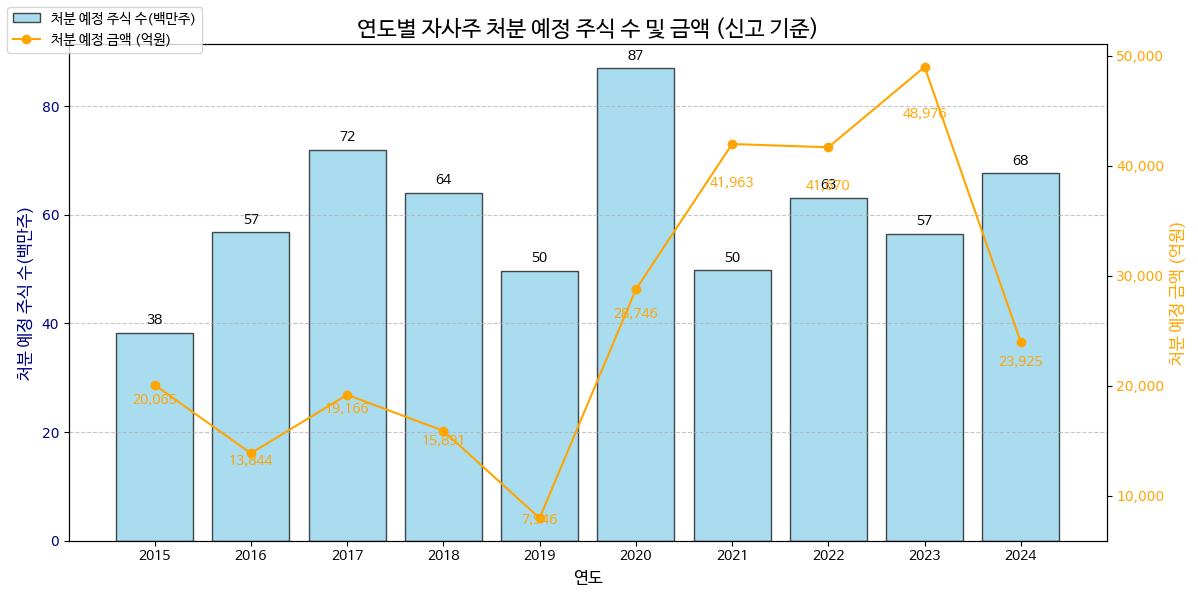

In [11]:
# 연도별 처분예정주식(주) 및 처분예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '처분예정주식': 'sum',
    '처분예정금액': 'sum'
})

# 단위 변환
annual_summary['처분예정주식'] = annual_summary['처분예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 처분 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['처분예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='처분 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 처분 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['처분예정금액'],
                 color='orange', marker='o', label='처분 예정 금액 (억원)')
ax2.set_ylabel('처분 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['처분예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 처분 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


표 형태로 숫자를 보면 아래와 같습니다. (주식수는 백만주단위, 금액은 억원 단위입니다.)

In [14]:
annual_summary_show = annual_summary.copy()

# 숫자 열을 정수로 변환
annual_summary_show['처분예정주식'] = annual_summary_show['처분예정주식'].astype(int)
annual_summary_show['처분예정금액'] = annual_summary_show['처분예정금액'].astype(int)

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 함수를 데이터프레임의 숫자 열에 적용
annual_summary_show['처분예정주식'] = annual_summary_show['처분예정주식'].apply(add_commas)
annual_summary_show['처분예정금액'] = annual_summary_show['처분예정금액'].apply(add_commas)

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = annual_summary_show.reset_index().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

annual_summary_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>연도</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2015</td>
      <td>38</td>
      <td>20,064</td>
    </tr>
    <tr>
      <td>2016</td>
      <td>56</td>
      <td>13,843</td>
    </tr>
    <tr>
      <td>2017</td>
      <td>71</td>
      <td>19,165</td>
    </tr>
    <tr>
      <td>2018</td>
      <td>64</td>
      <td>15,890</td>
    </tr>
    <tr>
      <td>2019</td>
      <td>49</td>
      <td>7,946</td>
    </tr>
    <tr>
      <td>2020</td>
      <td>87</td>
      <td>28,746</td>
    </tr>
    <tr>
      <td>2021</td>
      <td>49</td>
      <td>41,963</td>
    </tr>
    <tr>
      <td>2022</td>
      <td>63</td>
      <td>41,669</td>
    </tr>
    <tr>
      <td>2023</td>
      <td>56</td>
      <td>48,976</td>
    </tr>
    <tr>
      <td>2024</td>
      <td>67</td>
      <td>23,924</td>
    </tr>
  </tbody>
</table>


,처분예정주식,처분예정금액
연도,,
2015,38,"20,064"
2016,56,"13,843"
2017,71,"19,165"
2018,64,"15,890"
2019,49,"7,946"
2020,87,"28,746"
2021,49,"41,963"
2022,63,"41,669"
2023,56,"48,976"


#### 금감원 공시에서 장내 vs 장외 구분자 활용하기
앞서말씀드렸다시피, 자사주처분공시에서는 '처분방법'을 방법별 주식수로 기재하고 있습니다. 이렇게 장내, 장외를 미리 구분해주었으므로, 이를 바탕으로 붙석을 진행합니다.

annual_summary 데이터프레임은 한번 피벗을 한 데이터프레임입니다. 따라서 다시 df_dart_buyback 데이터프레임부터 시작합니다.<br>
* 처분방법별(장내, 시간외, 장외, 기타) 연도별로 처분예정주식수를 더합니다(sum)

In [15]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

표 형태로 숫자를 보면 아래와 같습니다.

In [16]:
# 데이터프레임 복사
df_dart_buyback_summary_show = df_dart_buyback_summary.copy()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_dart_buyback_summary_show[col] = df_dart_buyback_summary_show[col].astype(int) # 숫자 열을 정수로 변환
    df_dart_buyback_summary_show[col] = df_dart_buyback_summary_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback_summary_show.reset_index().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_dart_buyback_summary_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>연도</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2015</td>
      <td>1,666,192</td>
      <td>16,530,938</td>
      <td>7,844,437</td>
      <td>15,744,490</td>
    </tr>
    <tr>
      <td>2016</td>
      <td>2,419,163</td>
      <td>25,968,389</td>
      <td>18,675,063</td>
      <td>9,884,586</td>
    </tr>
    <tr>
      <td>2017</td>
      <td>2,326,848</td>
      <td>54,013,232</td>
      <td>7,990,151</td>
      <td>7,754,133</td>
    </tr>
    <tr>
      <td>2018</td>
      <td>40,406</td>
      <td>34,524,186</td>
      <td>7,851,419</td>
      <td>22,012,265</td>
    </tr>
    <tr>
      <td>2019</td>
      <td>1,284,314</td>
      <td>19,285,874</td>
      <td>21,949,696</td>
      <td>7,368,980</td>
    </tr>
    <tr>
      <td>2020</td>
      <td>564,590</td>
      <td>45,215,194</td

,장내매매,시간외대량매매,장외매매,기타
연도,,,,
2015,"1,666,192","16,530,938","7,844,437","15,744,490"
2016,"2,419,163","25,968,389","18,675,063","9,884,586"
2017,"2,326,848","54,013,232","7,990,151","7,754,133"
2018,"40,406","34,524,186","7,851,419","22,012,265"
2019,"1,284,314","19,285,874","21,949,696","7,368,980"
2020,"564,590","45,215,194","25,351,606","16,336,791"
2021,"126,896","16,399,457","12,301,222","5,590,723,510"
2022,"33,378","21,480,163","31,977,601","10,051,889"
2023,"1,137,914","8,749,493","6,362,146","851,245,528"


###### 처분방법별 자사주 처분 시각화

###### 공시에서 발견된 오타들!
시각화를 해서 보던 중, 아래와 같은 그림이 그려졌습니다.

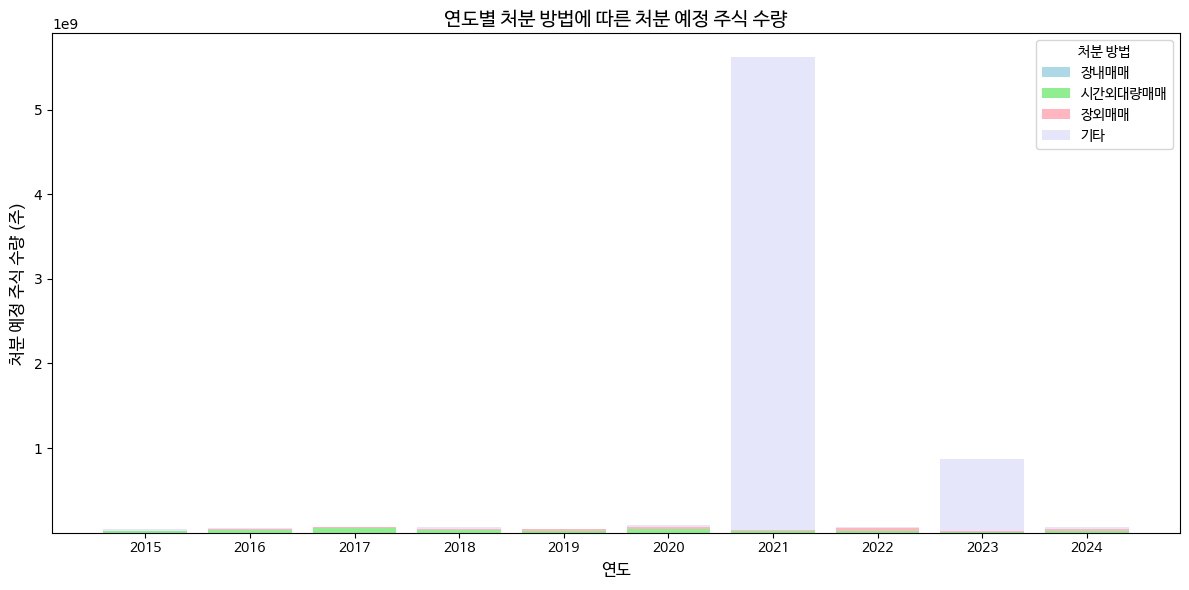

In [17]:
# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']
# 사용 가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary.columns):
    ax1.bar(
        df_dart_buyback_summary.index,  # 연도
        df_dart_buyback_summary[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )
    bottom_stack += df_dart_buyback_summary[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary.index)
ax1.set_xticklabels(df_dart_buyback_summary.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

원래는 앞서 그려보았던 바차트와 동일한 그림이 나오고, 바차트 안에서만 색깔이 나뉘어야 합니다. <br>
그런데 이렇게 바차트의 형태 자체가 달라져버렸습니다. 2021년의 기타처분 수량이 비정상적으로 높은 수치를 나타내고 있습니다. 왜일까요? <br><br>
> 원래 알던 것과 다르다면, 데이터의 출처가 달라지진 않았는지 한번 확인해 보아야 합니다.


<br>
기존에 그렸던 차트는 ***"처분예정주식수"***에서 가져온 데이터였고, 이번에 그린차트는 ***"처분방법별 처분주식수"***에서 가져온 데이터였습니다.<br>

추정컨대, 처분방법별 처분주식수를 기재하는 가정에서 오타가 났을 가능성이 있습니다.<br><br>

따라서 아래와 같이 필터를 적용해서 데이터를 직접 확인해보겠습니다. 2021년 데이터 중, 처분방법이 기타인 것을 기준으로 내림차순으로 정리해 봅니다.


In [18]:
# 그림이 이상하게 나와서 아웃라이어를 확인
df_show = df_dart_buyback[df_dart_buyback['연도'] == 2021]

# 데이터프레임 복사
df_show = df_show.sort_values(by='기타', ascending=False).head()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_show[col] = df_show[col].astype(int) # 숫자 열을 정수로 변환
    df_show[col] = df_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>카카오</td>
      <td>2021-11-03</td>
      <td>43512.0</td>
      <td>55.695360</td>
      <td>2021년 11월 04일</td>
      <td>2022년 01월 03일</td>
      <td>임직원에 대한 상여금 지급</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>5,569,536,000</td>
      <td>2021</td>
    </tr>
    <tr>
      <td>한국가스공사</td>
      <td>2021-11-12</td>
      <td>6486050.0</td>
      <td>3353.287850</td>
      <td>2021년 11월 16일</td>
      <td>2021년 11월 16일</td>
      <td>자기주식을 교환대상으로 하는 (사모후순위) 교환사채의 발행</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>6,486,050</td>
      <td>2021</td>
    </tr>
    <tr>
   

,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
69,카카오,2021-11-03,43512.0,55.695360,2021년 11월 04일,2022년 01월 03일,임직원에 대한 상여금 지급,0,0,0,"5,569,536,000",2021
91,한국가스공사,2021-11-12,6486050.0,3353.287850,2021년 11월 16일,2021년 11월 16일,자기주식을 교환대상으로 하는 (사모후순위) 교환사채의 발행,0,0,0,"6,486,050",2021
0,POSCO홀딩스,2021-08-26,2932480.0,14499.650880,2021년 09월 01일,2021년 09월 01일,자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분,0,0,0,"2,932,480",2021
87,남성,2021-07-21,2438429.0,100.000000,2021년 07월 23일,2021년 07월 23일,자기주식을 교환대상으로 하는 사모 교환사채의 발행으로 인한 자기주식 처분,0,0,0,"2,438,429",2021
1,화신,2021-10-13,1995600.0,232.128192,2021년 10월 15일,2021년 10월 15일,자기주식을 교환대상으로 하는 교환사채 발행,0,0,0,"1,995,600",2021


2021년 11월 3일에 최종 제출된 카카오의 자기주식처분공시에서 기타처분 주식수가 엄청나게 큰 것을 확인할 수 있습니다. 55로 시작하는 걸 보니... 처분예정금액(55억원)을 실수로 기재한 것이 아닌가 추론해 볼수 있습니다.

공시에서 기재한 총 처분주식수가 43,512주이고, 장내,시간외,장외가 모두 0주였으므로 기타도 43,512주여야함을 알 수 있습니다. <br>
그렇게 수정하도록 하겠습니다.

In [19]:
# 조건에 맞는 행의 특정 칼럼 값을 수정
df_dart_buyback.loc[
    (df_dart_buyback['회사명'] == "카카오") &
    (df_dart_buyback['접수일'] == datetime(2021, 11, 3)),
    '기타'
] = 43512

# 잘반영되었는지 확인
df_show = df_dart_buyback[
    (df_dart_buyback['회사명'] == "카카오") &
    (df_dart_buyback['접수일'] == datetime(2021, 11, 3))
]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>카카오</td>
      <td>2021-11-03</td>
      <td>43512.0</td>
      <td>55.69536</td>
      <td>2021년 11월 04일</td>
      <td>2022년 01월 03일</td>
      <td>임직원에 대한 상여금 지급</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>43512.0</td>
      <td>2021</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
69,카카오,2021-11-03,43512.0,55.69536,2021년 11월 04일,2022년 01월 03일,임직원에 대한 상여금 지급,0.0,0.0,0.0,43512.0,2021


잘 반영된 것 같으니, 이제 다시 시각화를 실행해 보겠습니다.<br>
시각화를 위해서 앞서 실행했던 피벗을 먼저 다시 실행합니다. 숫자가 바뀌었으니 sum을 다시 구해야겠죠.

In [20]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

이제 시각화를 실행해 봅니다.

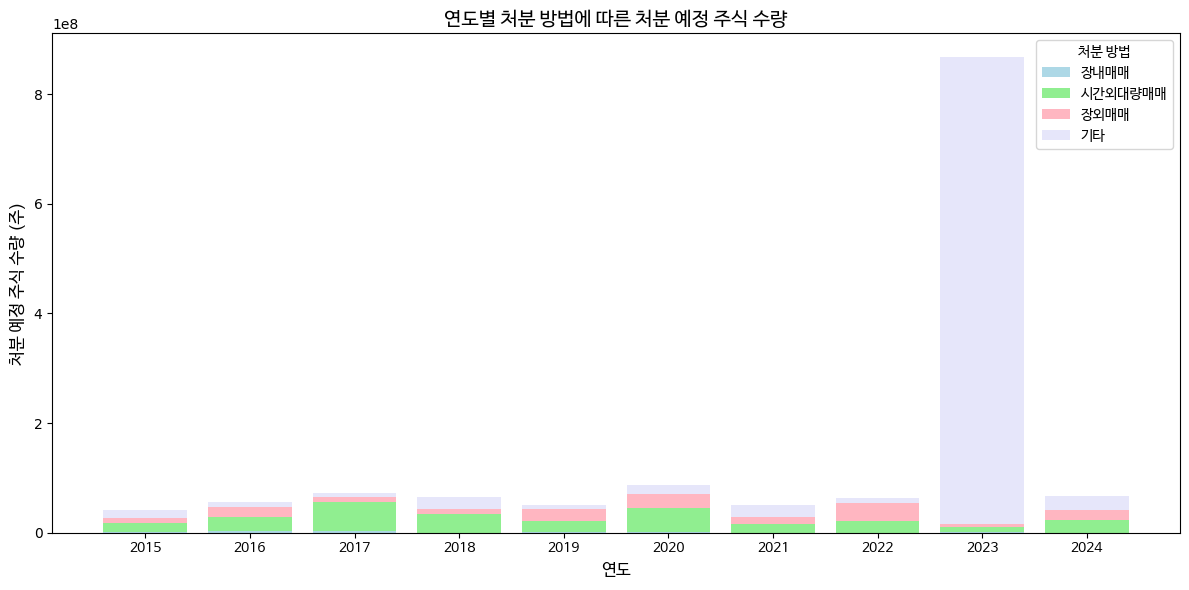

In [21]:
# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']
# 사용 가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary.columns):
    ax1.bar(
        df_dart_buyback_summary.index,  # 연도
        df_dart_buyback_summary[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )
    bottom_stack += df_dart_buyback_summary[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary.index)
ax1.set_xticklabels(df_dart_buyback_summary.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

이번엔 2023년의 기타처분 주식수가 말썽입니다. 이전과 동일하게 필터를 해서 어떤 회사가 공시에서 오타를 내었는지 확인해 봅니다.

In [22]:
# 그림이 이상하게 나와서 아웃라이어를 확인
df_show = df_dart_buyback[df_dart_buyback['연도'] == 2023]

# 데이터프레임 복사
df_show = df_show.sort_values(by='기타', ascending=False).head()

# 대상 칼럼
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
for col in columns_to_convert:
    df_show[col] = df_show[col].astype(int) # 숫자 열을 정수로 변환
    df_show[col] = df_show[col].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>TP</td>
      <td>2023-04-21</td>
      <td>493460.0</td>
      <td>8.112482</td>
      <td>2023년 04월 20일</td>
      <td>2023년 04월 28일</td>
      <td>자기주식 상여지급</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>811,248,240</td>
      <td>2023</td>
    </tr>
    <tr>
      <td>SK하이닉스</td>
      <td>2023-04-04</td>
      <td>20126911.0</td>
      <td>22377.100000</td>
      <td>2023년 04월 11일</td>
      <td>2023년 04월 11일</td>
      <td>자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
      <td>20,126,911</td>
      <td>2023</td>
    </tr>
    <tr>
      <td>

,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
3,TP,2023-04-21,493460.0,8.112482,2023년 04월 20일,2023년 04월 28일,자기주식 상여지급,0,0,0,"811,248,240",2023
80,SK하이닉스,2023-04-04,20126911.0,22377.100000,2023년 04월 11일,2023년 04월 11일,자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분,0,0,0,"20,126,911",2023
55,LS네트웍스,2023-09-22,5320054.0,256.799007,2023년 09월 22일,2023년 09월 22일,자기주식을 교환대상으로 하는 교환사채 발행,0,0,0,"5,320,054",2023
58,SK이노베이션,2023-02-06,2799970.0,4815.948400,2023년 03월 31일,2023년 04월 30일,기말 배당,0,0,0,"2,799,970",2023
60,아이마켓코리아,2023-05-10,1964500.0,232.695025,2023년 05월 12일,2023년 05월 12일,자기주식을 교환대상으로 하는 교환사채 발행,0,0,0,"1,964,500",2023


2023년 4월 21일에 최종 제출된 TP의 자기주식처분공시에서 기타처분 주식수가 엄청나게 큰 것을 확인할 수 있습니다. 811로 시작하는 걸 보니... 처분예정금액(8.11억원)을 실수로 기재한 것이 아닌가 추론해 볼수 있습니다. 카카오와 비슷한 실수네요.

공시에서 기재한 총 처분주식수가 493,460주이고, 장내,시간외,장외가 모두 0주였으므로 기타도 493,460주여야함을 알 수 있습니다. <br>
그렇게 수정하도록 하겠습니다.

In [23]:
# 조건에 맞는 행의 특정 칼럼 값을 수정
df_dart_buyback.loc[
    (df_dart_buyback['회사명'] == "TP") &
    (df_dart_buyback['접수일'] == datetime(2023, 4, 21)),
    '기타'
] = 493460

# 잘반영되었는지 확인
df_show = df_dart_buyback[
    (df_dart_buyback['회사명'] == "TP") &
    (df_dart_buyback['접수일'] == datetime(2023, 4, 21))
]

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>TP</td>
      <td>2023-04-21</td>
      <td>493460.0</td>
      <td>8.112482</td>
      <td>2023년 04월 20일</td>
      <td>2023년 04월 28일</td>
      <td>자기주식 상여지급</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>493460.0</td>
      <td>2023</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
3,TP,2023-04-21,493460.0,8.112482,2023년 04월 20일,2023년 04월 28일,자기주식 상여지급,0.0,0.0,0.0,493460.0,2023


잘 반영된 것 같으니, 이제 다시 시각화를 실행해 보겠습니다.<br>
시각화를 위해서 앞서 실행했던 피벗을 먼저 다시 실행합니다. 숫자가 바뀌었으니 sum을 다시 구해야겠죠.

In [24]:
# 데이터 타입 변경
columns_to_convert = ['장내매매', '시간외대량매매', '장외매매', '기타']

for col in columns_to_convert:
    df_dart_buyback[col] = pd.to_numeric(df_dart_buyback[col], errors='coerce').fillna(0)

# 연도별 방법별 처분예정주식(주) 집계
df_dart_buyback_summary = df_dart_buyback.groupby('연도').agg({
    '장내매매': 'sum',
    '시간외대량매매': 'sum',
    '장외매매': 'sum',
    '기타': 'sum'
})

###### 다시! 처분방법별 자사주 처분 시각화
이제 시각화를 실행해 봅니다.

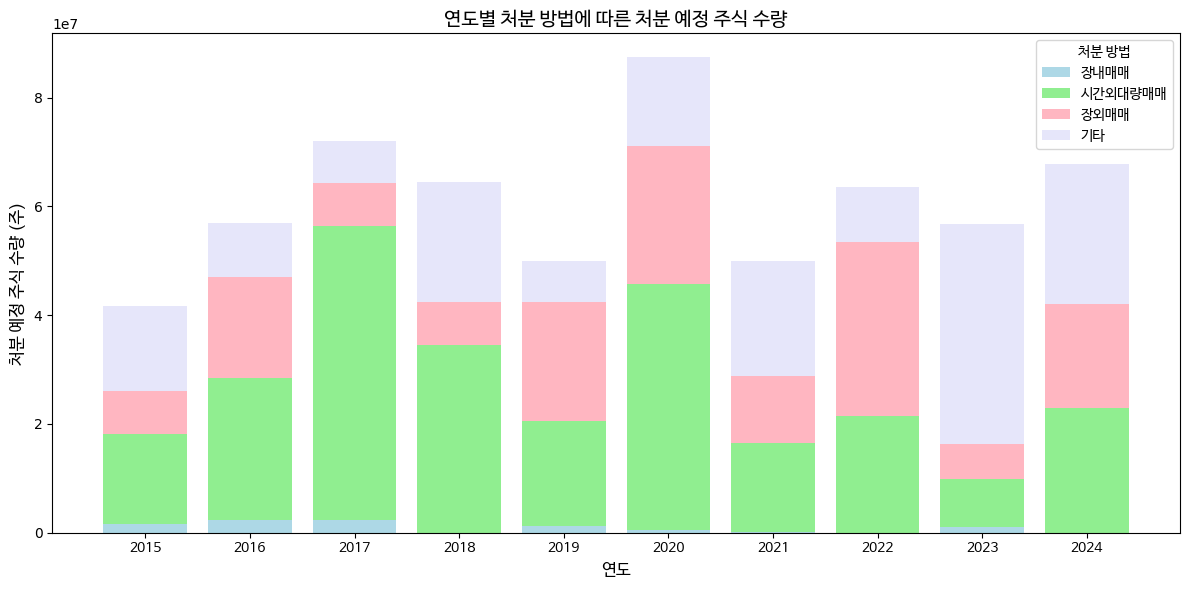

In [25]:
# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']
# 사용 가능한 색상: lightblue, lightpink, lightgreen, lavender, peachpuff, powderblue, palegoldenrod, thistle, honeydew, mistyrose

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary.columns):
    ax1.bar(
        df_dart_buyback_summary.index,  # 연도
        df_dart_buyback_summary[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )
    bottom_stack += df_dart_buyback_summary[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary.index)
ax1.set_xticklabels(df_dart_buyback_summary.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

오! 이전에 그렸던 그림과 비교하니 이제 맞는 바차트가 나왔습니다. 데이터레이블을 추가해 보겠습니다.

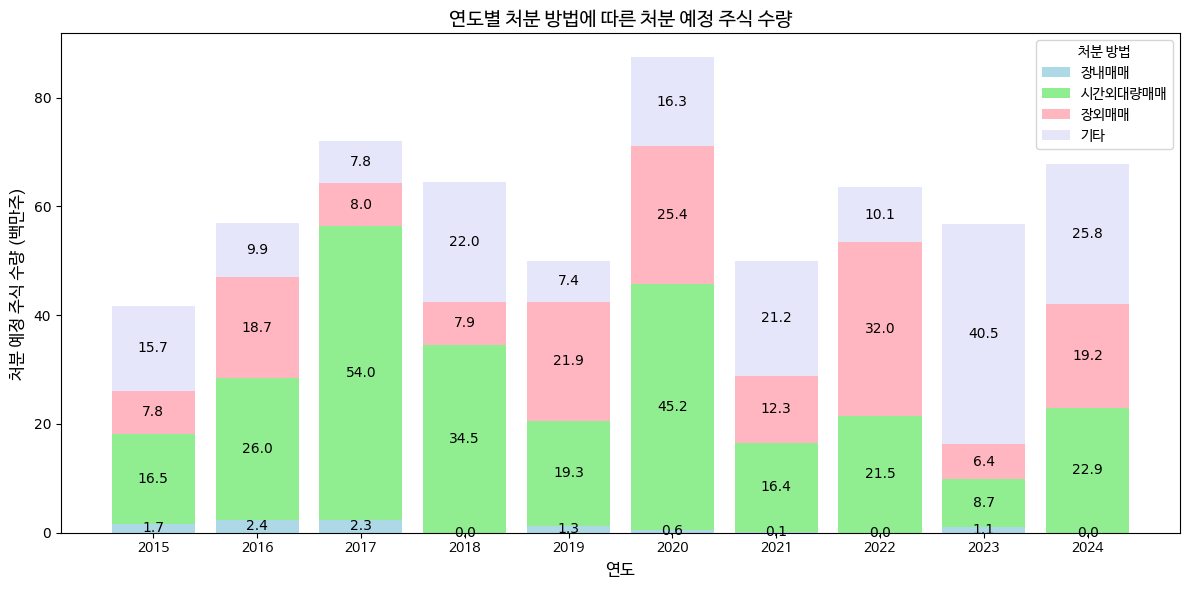

In [26]:
# 데이터를 백만 단위로 변환
df_dart_buyback_summary_millions = df_dart_buyback_summary / 1_000_000

# 1. 연도별 방법별 처분 예정 주식 스택드 바 차트
fig, ax1 = plt.subplots(figsize=(12, 6))

# 색상 설정
colors = ['lightblue', 'lightgreen', 'lightpink', 'lavender']

# 스택 초기값
bottom_stack = np.zeros(len(df_dart_buyback_summary_millions))

# 스택드 바 차트 생성
for idx, col in enumerate(df_dart_buyback_summary_millions.columns):
    bars = ax1.bar(
        df_dart_buyback_summary_millions.index,  # 연도
        df_dart_buyback_summary_millions[col],  # 데이터 값
        bottom=bottom_stack,  # 누적된 값
        label=col,  # 범례를 위한 레이블 추가
        color=colors[idx]  # 지정된 색상
    )

    # 데이터 레이블 추가
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # 값이 0보다 큰 경우에만 레이블 표시
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_y() + height/2,
                     f'{height:.1f}', ha='center', va='center')

    bottom_stack += df_dart_buyback_summary_millions[col]  # 다음 스택을 위해 업데이트

# X축, Y축 및 제목 폰트 설정
ax1.set_xticks(df_dart_buyback_summary_millions.index)
ax1.set_xticklabels(df_dart_buyback_summary_millions.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수량 (백만주)', fontproperties=font, fontsize=12)

# Legend 설정 (폰트 적용)
legend = ax1.legend(
    title='처분 방법',
    title_fontproperties=font,  # 제목 폰트 설정
    fontsize=10,
    prop=font  # 항목 폰트 설정
)

# 차트 제목
plt.title('연도별 처분 방법에 따른 처분 예정 주식 수량', fontproperties=font, fontsize=14)
plt.tight_layout()
plt.show()

###### 자사주 처분 시사점
장내에서 자사주를 처분하는 수량은 정말 낮았습니다. 아무래도 시장에 자사주 물량을 풀게 되면, 자사의 주가가 낮아지는 압력을 받을텐데, 쉽지 않은 결정일 것이라는 생각은 들었습니다. 그런 생각이 들었는데, 실제로 수치로 확인하게 되니 신기하기도 합니다.<br>
통상 거래상대방이 정해져있는 장외매매와 시간외대량매매를 제외한 '기타' 처분 방법은 어떤 예시가 있을까요? 한번 확인해보겠습니다.

In [27]:
# 처분방법이 기타인 것이 0이 아닌 것으로 필터
df_show = df_dart_buyback[df_dart_buyback['기타'] != 0]

# 데이터프레임 복사
df_show = df_show.sort_values(by='기타', ascending=False).head(10)

# 천 단위 콤마를 추가하는 함수 정의
def add_commas(x):
    return '{:,}'.format(x)

# 데이터 타입 변경
df_show['기타'] = df_show['기타'].astype(int) # 숫자 열을 정수로 변환
df_show['기타'] = df_show['기타'].apply(add_commas) # 함수를 데이터프레임의 숫자 열에 적용

# 결과 출력
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

df_show

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>처분예정주식</th>
      <th>처분예정금액</th>
      <th>처분시작일</th>
      <th>처분종료일</th>
      <th>처분목적</th>
      <th>장내매매</th>
      <th>시간외대량매매</th>
      <th>장외매매</th>
      <th>기타</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SK하이닉스</td>
      <td>2023-04-04</td>
      <td>20126911.0</td>
      <td>22377.100000</td>
      <td>2023년 04월 11일</td>
      <td>2023년 04월 11일</td>
      <td>자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>20,126,911</td>
      <td>2023</td>
    </tr>
    <tr>
      <td>한국가스공사</td>
      <td>2021-11-12</td>
      <td>6486050.0</td>
      <td>3353.287850</td>
      <td>2021년 11월 16일</td>
      <td>2021년 11월 16일</td>
      <td>자기주식을 교환대상으로 하는 (사모후순위) 교환사채의 발행</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>6,486,050</td>
      <t

,회사명,접수일,처분예정주식,처분예정금액,처분시작일,처분종료일,처분목적,장내매매,시간외대량매매,장외매매,기타,연도
80,SK하이닉스,2023-04-04,20126911.0,22377.100000,2023년 04월 11일,2023년 04월 11일,자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분,0.0,0.0,0.0,"20,126,911",2023
91,한국가스공사,2021-11-12,6486050.0,3353.287850,2021년 11월 16일,2021년 11월 16일,자기주식을 교환대상으로 하는 (사모후순위) 교환사채의 발행,0.0,0.0,0.0,"6,486,050",2021
75,대한전선,2018-10-11,6000000.0,30.000000,2018년 11월 05일,2025년 11월 05일,임직원 주식매수선택권 행사에 따른 자기주식 교부,0.0,0.0,0.0,"6,000,000",2018
55,LS네트웍스,2023-09-22,5320054.0,256.799007,2023년 09월 22일,2023년 09월 22일,자기주식을 교환대상으로 하는 교환사채 발행,0.0,0.0,0.0,"5,320,054",2023
97,윌비스,2020-12-09,5124450.0,70.000000,2020년 12월 11일,2020년 12월 11일,자기주식을 교환대상으로 하는 사모 교환사채 발행,0.0,0.0,0.0,"5,124,450",2020
38,KB금융,2020-06-18,5000000.0,2400.000000,2020년 06월 30일,2020년 06월 30일,자기주식을 교환대상으로 하는 교환사채 발행에 따른 처분,0.0,0.0,0.0,"5,000,000",2020
83,남성,2016-02-02,4938271.0,100.000000,2016년 02월 02일,2016년 02월 02일,자기주식을 교환대상으로하는 (사모)교환사채발행,0.0,0.0,0.0,"4,938,271",2016
29,잇츠한불,2017-02-17,4837001.0,1992.505822,2017년 05월 12일,2017년 05월 12일,합병신주에 갈음한 자기주식의 교부,0.0,0.0,0.0,"4,837,001",2017
90,카카오,2024-04-23,4599111.0,2929.633200,2024년 04월 29일,2024년 04월 29일,자기주식을 교환대상으로 하는 해외 외화표시 교환사채 발행에 따른 처분,0.0,0.0,0.0,"4,599,111",2024
32,SK네트웍스,2024-01-04,3415875.0,214.892696,2024년 01월 16일,2024년 01월 16일,소규모 주식교환 절차 진행,0.0,0.0,0.0,"3,415,875",2024


기타방식으로 처분한 자기주식 상위 10개의 공시문서상 처분목적을 살펴보니 교환사채를 발행한 경우가 많았습니다. <br>
사채인데, 권리를 행사하면 해당 주식을 배부하는 것이 교환사채입니다. 이런 사채를 발행하면서 자기주식을 처분하게 되는 경우가 '기타'의 주요 사유가 된다는 것을 확인하였습니다.